In [29]:
from keras.models import Model
from keras.layers import Input, Conv3D, ConvLSTM2D, ConvLSTM3D, BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
import glob
import json

In [30]:
def load_npy(folder): # used for MOD14A2, MOD13Q1
    mod14 = folder + '/MOD14A2*.npy'
    mod13 = folder + '/MOD13Q1*.npy'
    mod14g = glob.glob(mod14)
    mod13g = glob.glob(mod13)
    mod14g.sort()
    mod13g.sort()

#     times = min(len(mod14g), len(mod13g))
#     if times < frames:
#         return
    times=25
    res = np.zeros(shape=(1, times, dims, dims, channels))
    for i in range(times):
        #arr14 = np.load(mod14g[i])
        arr13 = np.load(mod13g[i])
        print(mod13g[i])
#         if (arr14.shape != (dims, dims)) or (arr13.shape != (dims, dims)):
#             return
        #arr14 = arr14[np.newaxis, np.newaxis, :, :]
        #arr14 = arr14*0.0001
        arr13 = arr13[np.newaxis, :, :]
        arr13 = arr13*0.0001
        arr13 = np.transpose(arr13, (0, 2, 3, 1))
        #res[:, i, :, :, 0] = arr14
        res[:, i, :, :, :] = arr13

    print(res.shape)
    return res

In [31]:
dims = 50
frames = 25
channels = 2

path = '/home/fun/wildfire_data/*'
files = glob.glob(path)
file_list = np.array([])
data = np.zeros(shape=(0, frames, dims, dims, channels))

for file in files:
    prof = file + '/profile.json'
    try:
        f = open(prof)
        info = json.load(f)
        if info['info']['acres_burned'] >= 10000:
            arr = load_npy(file) # many fires (~30) do not have an acres_burned value, instead it is an empty string "".
                                 # these fires are minor and only last around 1 or 2 months.
                                 # for now, doing a try except to get around this is good enough.
            arr = arr[:, -frames:, :, :, :]
            data = np.append(data, arr, axis=0)
            file_list = np.append(file_list, file)
    except:
        continue

print("FINAL SHAPE:", data.shape)

during = data[:, 0:frames-1, :, :, :] # all but last frame
#during = during[:, :, :, :, np.newaxis]

after = data[:, 1:, :, :, :] # missing first frame (shifted forward 1)
#after = after[:, :, :, :, np.newaxis]
print("x_train shape:", during.shape)
print("y_train shape:", after.shape)

/home/fun/wildfire_data/August_Complex_includes_Doe_Fire_2020-08-16/MOD13Q1_2020-08-28.npy
/home/fun/wildfire_data/August_Complex_includes_Doe_Fire_2020-08-16/MOD13Q1_2020-09-29.npy
/home/fun/wildfire_data/August_Complex_includes_Doe_Fire_2020-08-16/MOD13Q1_2020-10-31.npy
/home/fun/wildfire_data/August_Complex_includes_Doe_Fire_2020-08-16/MOD13Q1_2020-12-02.npy
/home/fun/wildfire_data/August_Complex_includes_Doe_Fire_2020-08-16/MOD13Q1_2021-01-17.npy
/home/fun/wildfire_data/August_Complex_includes_Doe_Fire_2020-08-16/MOD13Q1_2021-02-18.npy
/home/fun/wildfire_data/August_Complex_includes_Doe_Fire_2020-08-16/MOD13Q1_2021-03-22.npy
/home/fun/wildfire_data/August_Complex_includes_Doe_Fire_2020-08-16/MOD13Q1_2021-04-23.npy
/home/fun/wildfire_data/August_Complex_includes_Doe_Fire_2020-08-16/MOD13Q1_2021-05-25.npy
/home/fun/wildfire_data/August_Complex_includes_Doe_Fire_2020-08-16/MOD13Q1_2021-06-26.npy
/home/fun/wildfire_data/August_Complex_includes_Doe_Fire_2020-08-16/MOD13Q1_2021-07-28.npy

/home/fun/wildfire_data/Zogg_Fire_2020-09-27/MOD13Q1_2022-01-17.npy
/home/fun/wildfire_data/Zogg_Fire_2020-09-27/MOD13Q1_2022-02-18.npy
/home/fun/wildfire_data/Zogg_Fire_2020-09-27/MOD13Q1_2022-03-22.npy
/home/fun/wildfire_data/Zogg_Fire_2020-09-27/MOD13Q1_2022-04-23.npy
/home/fun/wildfire_data/Zogg_Fire_2020-09-27/MOD13Q1_2022-05-25.npy
/home/fun/wildfire_data/Zogg_Fire_2020-09-27/MOD13Q1_2022-06-26.npy
/home/fun/wildfire_data/Zogg_Fire_2020-09-27/MOD13Q1_2022-07-28.npy
/home/fun/wildfire_data/Zogg_Fire_2020-09-27/MOD13Q1_2022-08-29.npy
/home/fun/wildfire_data/Zogg_Fire_2020-09-27/MOD13Q1_2022-09-30.npy
(1, 25, 50, 50, 2)
/home/fun/wildfire_data/Walker_Fire_2019-09-04/MOD13Q1_2019-07-28.npy
/home/fun/wildfire_data/Walker_Fire_2019-09-04/MOD13Q1_2019-08-29.npy
/home/fun/wildfire_data/Walker_Fire_2019-09-04/MOD13Q1_2019-09-30.npy
/home/fun/wildfire_data/Walker_Fire_2019-09-04/MOD13Q1_2019-11-01.npy
/home/fun/wildfire_data/Walker_Fire_2019-09-04/MOD13Q1_2019-12-03.npy
/home/fun/wildfire_

/home/fun/wildfire_data/Tubbs_Fire_Central_LNU_Complex_2017-10-08/MOD13Q1_2019-07-28.npy
/home/fun/wildfire_data/Tubbs_Fire_Central_LNU_Complex_2017-10-08/MOD13Q1_2019-08-29.npy
/home/fun/wildfire_data/Tubbs_Fire_Central_LNU_Complex_2017-10-08/MOD13Q1_2019-09-30.npy
/home/fun/wildfire_data/Tubbs_Fire_Central_LNU_Complex_2017-10-08/MOD13Q1_2019-11-01.npy
/home/fun/wildfire_data/Tubbs_Fire_Central_LNU_Complex_2017-10-08/MOD13Q1_2019-12-03.npy
/home/fun/wildfire_data/Tubbs_Fire_Central_LNU_Complex_2017-10-08/MOD13Q1_2020-01-17.npy
/home/fun/wildfire_data/Tubbs_Fire_Central_LNU_Complex_2017-10-08/MOD13Q1_2020-02-18.npy
/home/fun/wildfire_data/Tubbs_Fire_Central_LNU_Complex_2017-10-08/MOD13Q1_2020-03-21.npy
/home/fun/wildfire_data/Tubbs_Fire_Central_LNU_Complex_2017-10-08/MOD13Q1_2020-04-22.npy
/home/fun/wildfire_data/Tubbs_Fire_Central_LNU_Complex_2017-10-08/MOD13Q1_2020-05-24.npy
/home/fun/wildfire_data/Tubbs_Fire_Central_LNU_Complex_2017-10-08/MOD13Q1_2020-06-25.npy
/home/fun/wildfire_da

/home/fun/wildfire_data/Taboose_Fire_2019-09-06/MOD13Q1_2021-12-19.npy
(1, 25, 50, 50, 2)
/home/fun/wildfire_data/Rim_Fire_2013-08-17/MOD13Q1_2013-06-10.npy
/home/fun/wildfire_data/Rim_Fire_2013-08-17/MOD13Q1_2013-07-12.npy
/home/fun/wildfire_data/Rim_Fire_2013-08-17/MOD13Q1_2013-08-13.npy
/home/fun/wildfire_data/Rim_Fire_2013-08-17/MOD13Q1_2013-09-14.npy
/home/fun/wildfire_data/Rim_Fire_2013-08-17/MOD13Q1_2013-10-16.npy
/home/fun/wildfire_data/Rim_Fire_2013-08-17/MOD13Q1_2013-11-17.npy
/home/fun/wildfire_data/Rim_Fire_2013-08-17/MOD13Q1_2013-12-19.npy
/home/fun/wildfire_data/Rim_Fire_2013-08-17/MOD13Q1_2014-02-02.npy
/home/fun/wildfire_data/Rim_Fire_2013-08-17/MOD13Q1_2014-03-06.npy
/home/fun/wildfire_data/Rim_Fire_2013-08-17/MOD13Q1_2014-04-07.npy
/home/fun/wildfire_data/Rim_Fire_2013-08-17/MOD13Q1_2014-05-09.npy
/home/fun/wildfire_data/Rim_Fire_2013-08-17/MOD13Q1_2014-06-10.npy
/home/fun/wildfire_data/Rim_Fire_2013-08-17/MOD13Q1_2014-07-12.npy
/home/fun/wildfire_data/Rim_Fire_2013-0

/home/fun/wildfire_data/Long_Valley_Fire_2017-07-11/MOD13Q1_2019-06-10.npy
/home/fun/wildfire_data/Long_Valley_Fire_2017-07-11/MOD13Q1_2019-07-12.npy
/home/fun/wildfire_data/Long_Valley_Fire_2017-07-11/MOD13Q1_2019-08-13.npy
/home/fun/wildfire_data/Long_Valley_Fire_2017-07-11/MOD13Q1_2019-09-14.npy
/home/fun/wildfire_data/Long_Valley_Fire_2017-07-11/MOD13Q1_2019-10-16.npy
/home/fun/wildfire_data/Long_Valley_Fire_2017-07-11/MOD13Q1_2019-11-17.npy
/home/fun/wildfire_data/Long_Valley_Fire_2017-07-11/MOD13Q1_2019-12-19.npy
(1, 25, 50, 50, 2)
/home/fun/wildfire_data/Detwiler_Fire_2017-07-16/MOD13Q1_2022-07-28.npy
/home/fun/wildfire_data/Detwiler_Fire_2017-07-16/MOD13Q1_2022-08-29.npy
/home/fun/wildfire_data/Detwiler_Fire_2017-07-16/MOD13Q1_2022-09-30.npy
/home/fun/wildfire_data/Detwiler_Fire_2017-07-16/MOD13Q1_2022-11-01.npy
/home/fun/wildfire_data/Detwiler_Fire_2017-07-16/MOD13Q1_2022-12-03.npy
/home/fun/wildfire_data/Detwiler_Fire_2017-07-16/MOD13Q1_2023-01-17.npy
/home/fun/wildfire_data/

/home/fun/wildfire_data/Stone_Fire_2018-08-15/MOD13Q1_2018-10-16.npy
/home/fun/wildfire_data/Stone_Fire_2018-08-15/MOD13Q1_2018-11-17.npy
/home/fun/wildfire_data/Stone_Fire_2018-08-15/MOD13Q1_2018-12-19.npy
/home/fun/wildfire_data/Stone_Fire_2018-08-15/MOD13Q1_2019-02-02.npy
/home/fun/wildfire_data/Stone_Fire_2018-08-15/MOD13Q1_2019-03-06.npy
/home/fun/wildfire_data/Stone_Fire_2018-08-15/MOD13Q1_2019-04-07.npy
/home/fun/wildfire_data/Stone_Fire_2018-08-15/MOD13Q1_2019-05-09.npy
/home/fun/wildfire_data/Stone_Fire_2018-08-15/MOD13Q1_2019-06-10.npy
/home/fun/wildfire_data/Stone_Fire_2018-08-15/MOD13Q1_2019-07-12.npy
/home/fun/wildfire_data/Stone_Fire_2018-08-15/MOD13Q1_2019-08-13.npy
/home/fun/wildfire_data/Stone_Fire_2018-08-15/MOD13Q1_2019-09-14.npy
/home/fun/wildfire_data/Stone_Fire_2018-08-15/MOD13Q1_2019-10-16.npy
/home/fun/wildfire_data/Stone_Fire_2018-08-15/MOD13Q1_2019-11-17.npy
/home/fun/wildfire_data/Stone_Fire_2018-08-15/MOD13Q1_2019-12-19.npy
/home/fun/wildfire_data/Stone_Fire

/home/fun/wildfire_data/Lake_Fire_2015-06-17/MOD13Q1_2015-11-17.npy
/home/fun/wildfire_data/Lake_Fire_2015-06-17/MOD13Q1_2015-12-19.npy
/home/fun/wildfire_data/Lake_Fire_2015-06-17/MOD13Q1_2016-02-02.npy
/home/fun/wildfire_data/Lake_Fire_2015-06-17/MOD13Q1_2016-03-05.npy
/home/fun/wildfire_data/Lake_Fire_2015-06-17/MOD13Q1_2016-04-06.npy
/home/fun/wildfire_data/Lake_Fire_2015-06-17/MOD13Q1_2016-05-08.npy
/home/fun/wildfire_data/Lake_Fire_2015-06-17/MOD13Q1_2016-06-09.npy
/home/fun/wildfire_data/Lake_Fire_2015-06-17/MOD13Q1_2016-07-11.npy
/home/fun/wildfire_data/Lake_Fire_2015-06-17/MOD13Q1_2016-08-12.npy
/home/fun/wildfire_data/Lake_Fire_2015-06-17/MOD13Q1_2016-09-13.npy
/home/fun/wildfire_data/Lake_Fire_2015-06-17/MOD13Q1_2016-10-15.npy
/home/fun/wildfire_data/Lake_Fire_2015-06-17/MOD13Q1_2016-11-16.npy
/home/fun/wildfire_data/Lake_Fire_2015-06-17/MOD13Q1_2016-12-18.npy
/home/fun/wildfire_data/Lake_Fire_2015-06-17/MOD13Q1_2017-02-02.npy
/home/fun/wildfire_data/Lake_Fire_2015-06-17/MOD

/home/fun/wildfire_data/Aspen_Fire_2013-07-22/MOD13Q1_2014-12-03.npy
/home/fun/wildfire_data/Aspen_Fire_2013-07-22/MOD13Q1_2015-01-17.npy
/home/fun/wildfire_data/Aspen_Fire_2013-07-22/MOD13Q1_2015-02-18.npy
/home/fun/wildfire_data/Aspen_Fire_2013-07-22/MOD13Q1_2015-03-22.npy
/home/fun/wildfire_data/Aspen_Fire_2013-07-22/MOD13Q1_2015-04-23.npy
/home/fun/wildfire_data/Aspen_Fire_2013-07-22/MOD13Q1_2015-05-25.npy
/home/fun/wildfire_data/Aspen_Fire_2013-07-22/MOD13Q1_2015-06-26.npy
/home/fun/wildfire_data/Aspen_Fire_2013-07-22/MOD13Q1_2015-07-28.npy
/home/fun/wildfire_data/Aspen_Fire_2013-07-22/MOD13Q1_2015-08-29.npy
(1, 25, 50, 50, 2)
/home/fun/wildfire_data/Helena_-_Fork_Fire_2017-08-30/MOD13Q1_2017-10-16.npy
/home/fun/wildfire_data/Helena_-_Fork_Fire_2017-08-30/MOD13Q1_2017-11-17.npy
/home/fun/wildfire_data/Helena_-_Fork_Fire_2017-08-30/MOD13Q1_2017-12-19.npy
/home/fun/wildfire_data/Helena_-_Fork_Fire_2017-08-30/MOD13Q1_2018-02-02.npy
/home/fun/wildfire_data/Helena_-_Fork_Fire_2017-08-3

/home/fun/wildfire_data/Corral_Complex_2013-08-10/MOD13Q1_2013-05-25.npy
/home/fun/wildfire_data/Corral_Complex_2013-08-10/MOD13Q1_2013-06-26.npy
/home/fun/wildfire_data/Corral_Complex_2013-08-10/MOD13Q1_2013-07-28.npy
/home/fun/wildfire_data/Corral_Complex_2013-08-10/MOD13Q1_2013-08-29.npy
/home/fun/wildfire_data/Corral_Complex_2013-08-10/MOD13Q1_2013-09-30.npy
/home/fun/wildfire_data/Corral_Complex_2013-08-10/MOD13Q1_2013-11-01.npy
/home/fun/wildfire_data/Corral_Complex_2013-08-10/MOD13Q1_2013-12-03.npy
/home/fun/wildfire_data/Corral_Complex_2013-08-10/MOD13Q1_2014-01-17.npy
/home/fun/wildfire_data/Corral_Complex_2013-08-10/MOD13Q1_2014-02-18.npy
/home/fun/wildfire_data/Corral_Complex_2013-08-10/MOD13Q1_2014-03-22.npy
/home/fun/wildfire_data/Corral_Complex_2013-08-10/MOD13Q1_2014-04-23.npy
/home/fun/wildfire_data/Corral_Complex_2013-08-10/MOD13Q1_2014-05-25.npy
/home/fun/wildfire_data/Corral_Complex_2013-08-10/MOD13Q1_2014-06-26.npy
/home/fun/wildfire_data/Corral_Complex_2013-08-10/M

In [32]:
inp = Input(shape=(None, 50, 50, 2))

x = ConvLSTM2D(filters=64, kernel_size=(5, 5), 
                   padding='same', return_sequences=True)(inp)
x = BatchNormalization()(x)

x = ConvLSTM2D(filters=64, kernel_size=(5, 5),
                   padding='same', return_sequences=True)(x)
x = BatchNormalization()(x)

x = ConvLSTM2D(filters=64, kernel_size=(5, 5),
                   padding='same', return_sequences=True)(x)
x = BatchNormalization()(x)

x = ConvLSTM2D(filters=64, kernel_size=(5, 5),
                   padding='same', return_sequences=True)(x)
x = BatchNormalization()(x)

x = Conv3D(filters=channels, kernel_size=(5, 5, 5),
               activation='softmax',
               padding='same', data_format='channels_last')(x)

model = Model(inp, x)
model.compile(loss='binary_crossentropy', optimizer='adam')

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 50, 50, 2)  0         
                             ]                                   
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (None, None, 50, 50, 64)  422656    
                                                                 
 batch_normalization_4 (Batc  (None, None, 50, 50, 64)  256      
 hNormalization)                                                 
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, None, 50, 50, 64)  819456    
                                                                 
 batch_normalization_5 (Batc  (None, None, 50, 50, 64)  256      
 hNormalization)                                                 
                                                           

In [17]:
model.fit(during, # timestamps during wildfire
        after, # predictions (timestamps to predict)
        batch_size=20,
        epochs=5,
        validation_split=0.20, 
       )

Epoch 1/5


2023-07-14 16:41:47.166688: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1920000000 exceeds 10% of free system memory.
2023-07-14 16:41:47.177975: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1920000000 exceeds 10% of free system memory.


1/1 [==============================] - 248s 248s/step - loss: -2507.3364 - val_loss: -8472.6338
Epoch 2/5


2023-07-14 16:45:43.713594: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1920000000 exceeds 10% of free system memory.


1/1 [==============================] - 262s 262s/step - loss: -7574.7939 - val_loss: 3298.0735
Epoch 3/5
1/1 [==============================] - 278s 278s/step - loss: -9419.1875 - val_loss: -31814.8398
Epoch 4/5
1/1 [==============================] - 274s 274s/step - loss: -15296.6709 - val_loss: -44075.3203
Epoch 5/5
1/1 [==============================] - 267s 267s/step - loss: -19250.7402 - val_loss: -54562.9609


(25, 50, 50, 2)
/home/fun/wildfire_data/Tubbs_Fire_Central_LNU_Complex_2017-10-08
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


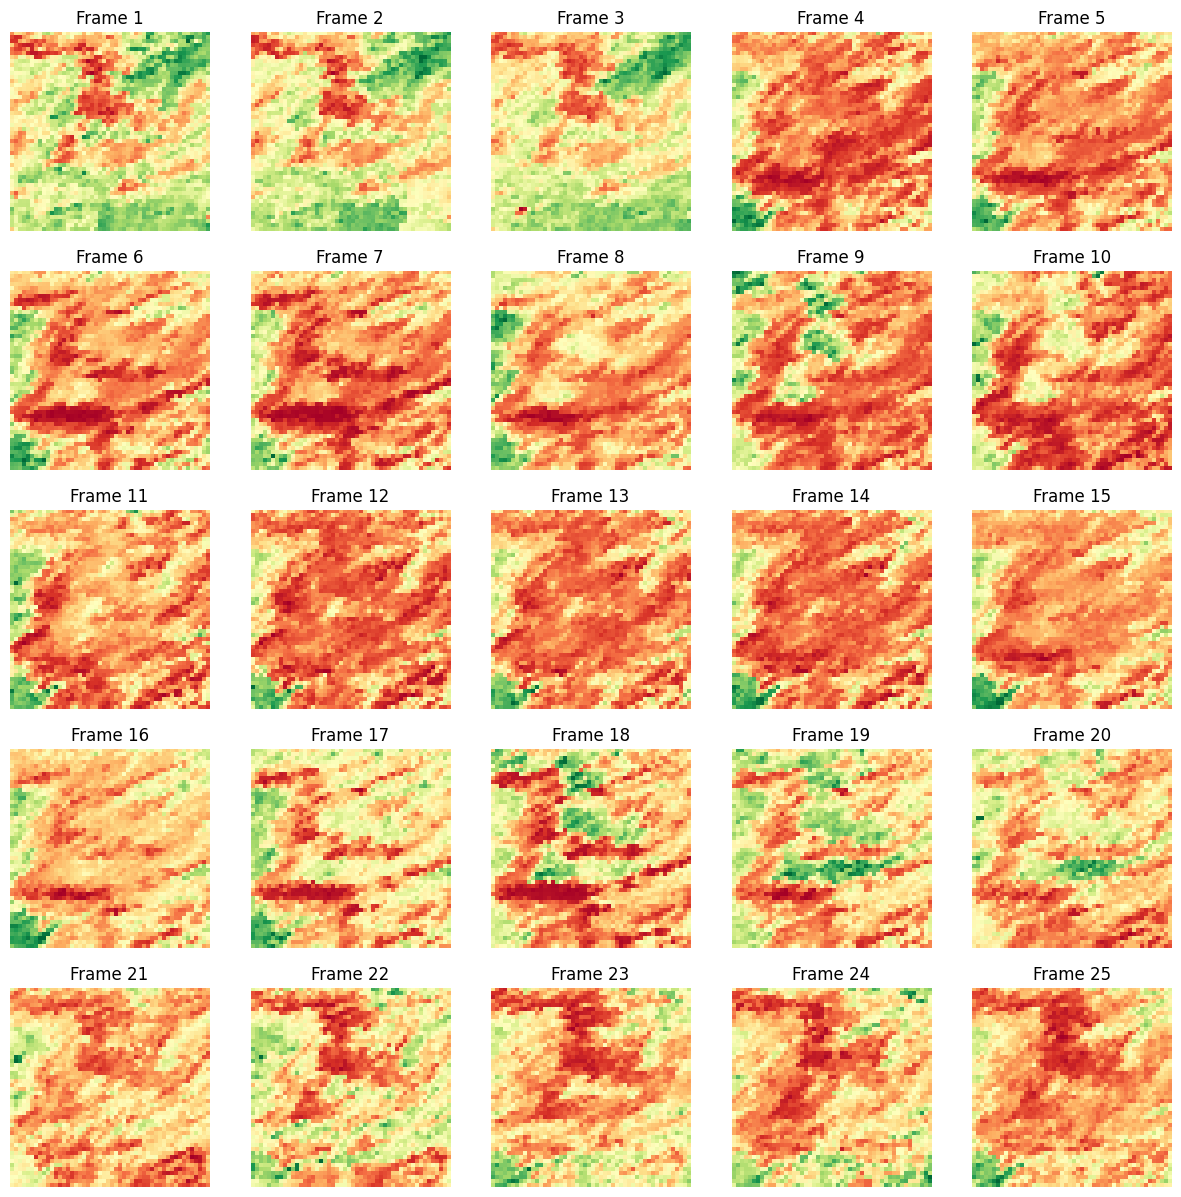

In [19]:
n = np.random.choice(range(len(data)), size=1)[0]
example = data[10]
print(example.shape)
print(file_list[n])

fig, axes = plt.subplots(5, 5, figsize=(15, 15))

for i in range(5):
    for idx, ax in enumerate(axes[i]):
        #print(idx)
        #print(example[idx, 20, 24:28, 1])
        arr = example[idx+5*i, :, :, 1]
        ax.imshow(arr, 
                  cmap='RdYlGn')
        ax.set_title(f"Frame {idx + 1 + 5*i}")
        ax.axis("off")
        print(np.count_nonzero(arr == -3000)) # replace small amts with 0, delete imgs with too much
        


SAMPLE: /home/fun/wildfire_data/Erskine_Fire_2016-06-23
(15, 50, 50, 2) (10, 50, 50, 2)
1/1 [==============================] - 1s 962ms/step


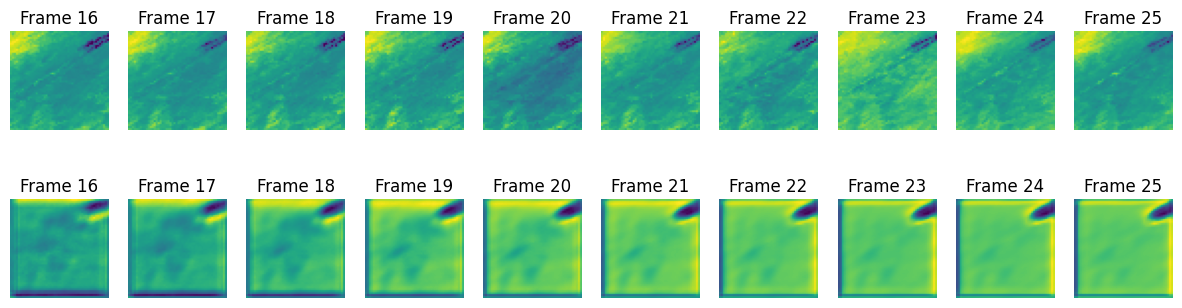

In [28]:
n = np.random.choice(range(len(data)), size=1)[0]
print("SAMPLE:", file_list[n])

example = data[n]
sample = example[:15, :, :, :]
actual = example[15:, :, :, :]
print(sample.shape, actual.shape)


for _ in range(10):
    new_prediction = model.predict(np.expand_dims(sample, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    frames = np.concatenate((sample, predicted_frame), axis=0)

fig, axes = plt.subplots(2, 10, figsize=(15, 4))

for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(actual[idx, :, :, 0]))
    ax.set_title(f"Frame {idx + 16}")
    ax.axis("off")

new_frames = sample[15:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_prediction[idx, :, :, 0]))
    ax.set_title(f"Frame {idx + 16}")
    ax.axis("off")

plt.show()